In [1]:
import numpy as np
import autograd.numpy as npa
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt
from autograd.scipy.signal import convolve as conv
from skimage.draw import circle
import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
import collections
from make_gif import make_gif
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [2]:
#----------------- Simulation Constants -----------------#
# The angular frequencies
omega1=2*np.pi*200e12
# Wavevector
k0=omega1/299792458
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=240
# Number of pixels in y-direction
Ny=240
# Number of pixels in the PMLs in each direction
Npml=40
# Minimum value of the relative permittivity
epsr_train_min=-1.0
epsr_train_max=12.0
# Maximum value of the relative permittivity
epsr_design=1.0
epsr_bckgd=12.0

#------------------- Domain Constants -------------------#
# Space between the PMLs and the design region (in pixels)
space=20
# Width of the waveguide (in pixels)
wg_width=24
# Length in pixels of the source/probe slices on each side of the center point
space_slice=16
# Number of dots in a row/column
num_dots=10
# Radius of dots
circle_rad=int((Nx-2*(Npml+space))/(2*num_dots))
# Lattice constant
ra=1

#---------------- Optimization Constants ----------------#
# Number of epochs in the optimization 
Nsteps=1000
# Step size for the Adam optimizer
step_size=5e-3

#------------------ Graphing Constants ------------------#
Emax=0
emin=-1
emax=12

In [3]:
def init_design(epsrs, Nx=Nx, Ny=Ny, Npml=Npml, space=space, num_dots=num_dots, circle_rad=circle_rad):
    # Selector for each plasma rod
    rods = [np.zeros((Nx, Ny)) for i in range(num_dots**2)]
    # Selector for entire design region
    design_region = np.zeros((Nx, Ny))
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    
    # Initialize selector for circular plasma rods
    center_x = Npml+space+circle_rad
    for i in range(num_dots):
        center_y = Npml+space+circle_rad
        for j in range(num_dots):
            r, c = circle(center_x, center_y, circle_rad*ra)
            rods[j + i*num_dots][r, c] = 1
            center_y = center_y + 2*circle_rad
        center_x = center_x + 2*circle_rad
        
    return rods, design_region
    
def init_guides(Nx=Nx, Ny=Ny, Npml=Npml, space=space, wg_width=wg_width, space_slice=space_slice, wg_shift=9):
    """Initializes waveguides and sources

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    bg_rho = np.zeros((Nx, Ny))
        
    # Input waveguide
    bg_rho[Nx//2-wg_width//2:Ny//2+wg_width//2,0:int(Npml+space)] = 1
    # Data waveguide 1
    bg_rho[0:int(Npml+space),Npml+space+wg_shift:Npml+space+wg_width+wg_shift] = 1
    # Data waveguide 2
    bg_rho[0:int(Npml+space),Ny-Npml-space-wg_width-wg_shift:Ny-Npml-space-wg_shift] = 1
    
    # Input probe slice
    input_slice = Slice(x=np.arange(Nx//2-wg_width//2-space_slice, Nx//2+wg_width//2+space_slice),
                        y=np.array(Npml+1))
    # Data probe slice 1
    data_slice1 = Slice(x=np.array(Npml+1),
                        y=np.arange(Npml+space-space_slice+wg_shift, Npml+space+wg_width+space_slice+wg_shift))
    # Data probe slice 2
    data_slice2 = Slice(x=np.array(Npml+1),
                        y=np.arange(Ny-Npml-space-wg_width-wg_shift-space_slice, Ny-Npml-space-wg_shift+space_slice))
    input_slices = [input_slice, data_slice1, data_slice2]
    
    # Output waveguide
    bg_rho[int(Nx-Npml-space)::,Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    # Ground waveguide
    bg_rho[Nx//2-wg_width//2:Nx//2+wg_width//2,int(Ny-Npml-space)::] = 1
    
    # Output probe slice
    output_slice = Slice(x=np.array(Nx-Npml-1),
                         y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))
    #Ground probe slice
    ground_slice = Slice(x=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice),
                         y=np.array(Ny-Npml-1))
    output_slices = [output_slice, ground_slice]
            
    return bg_rho, input_slices, output_slices

def init_domain(epsrs):
    rods, design_region = init_design(epsrs)
    bg_rho, input_slices, output_slices = \
        init_guides(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice, wg_shift=18)
    return bg_rho, design_region, rods, input_slices, output_slices

In [4]:
# set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def real(val, outline=None, ax=None, cbar=False, cmap='RdBu', outline_alpha=0.5, vmin=None, vmax=None):
    """Plots the real part of 'val', optionally overlaying an outline of 'outline'
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)
    
    if vmin is None:
        vmax = np.real(val).max()
        vmin = np.real(val).min()
    h = ax.imshow(np.real(val.T), cmap=cmap, origin='lower left', clim=(vmin, vmax), \
                  norm=MidpointNormalize(midpoint=0,vmin=vmin,vmax=vmax))
    
    if outline is not None:
        ax.contour(outline.T, 0, colors='k', alpha=outline_alpha)
    
    if cbar:
        cbar = plt.colorbar(h, ax=ax)
        cbar.set_ticks([-1, 0, 6, 12])
        cbar.set_ticklabels(['-1', '0', '6', '12'])
    
    return ax

def abslt(val, outline=None, ax=None, cbar=False, cmap='magma', outline_alpha=0.5, outline_val=None, vmax=None):
    """Plots the absolute value of 'val', optionally overlaying an outline of 'outline'
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)      
    
    if vmax is None:
        vmax = np.abs(val).max()
    h = ax.imshow(np.abs(val.T), cmap=cmap, origin='lower left', vmin=0, vmax=vmax)
    
    if outline_val is None and outline is not None: outline_val = 0.5*(outline.min()+outline.max())
    if outline is not None:
        ax.contour(outline.T, [outline_val], colors='w', alpha=outline_alpha)
    
    if cbar:
        cbar = plt.colorbar(h, ax=ax)
        cbar.set_ticks([])
        cbar.ax.set_ylabel('Electric Field Strength')
    
    return ax

In [5]:
def viz_sim(epsr, source, dataA, dataB, slices=[], log=0):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    global emin, emax, Emax
    
    simulation = fdfd_ez(omega1, dl, epsr, [Npml, Npml])
    _, _, Ez00 = simulation.solve(source)
    _, _, Ez01 = simulation.solve(source+dataB)
    _, _, Ez10 = simulation.solve(source+dataA)
    _, _, Ez11 = simulation.solve(source+dataA+dataB)
    
    epsr_graph = np.array(epsr, copy=True)
    epsr_graph[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0
    
    fig, axs = plt.subplots(1, 5, constrained_layout=True, figsize=(16,4))
    abslt(Ez00, outline=epsr_graph, ax=axs[0], cbar=False)
    abslt(Ez01, outline=epsr_graph, ax=axs[1], cbar=False)
    abslt(Ez10, outline=epsr_graph, ax=axs[2], cbar=False)
    abslt(Ez11, outline=epsr_graph, ax=axs[3], cbar=True)
    real(epsr, ax=axs[4], cmap='RdGy', cbar=True, vmin=-1, vmax=12)
    for sl in slices:
        for ax in axs:
            try:
                ax.plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
            except:
                ax.plot(sl.x, sl.y*np.ones(len(sl.x)), 'w-', alpha=0.5)
    
    if log:
        Estack = np.dstack((Ez00, Ez01, Ez10, Ez11))
        np.savetxt('or_te/Ez00_%03d.csv' % log, np.abs(Ez00), delimiter=',')
        np.savetxt('or_te/Ez01_%03d.csv' % log, np.abs(Ez01), delimiter=',')
        np.savetxt('or_te/Ez10_%03d.csv' % log, np.abs(Ez10), delimiter=',')
        np.savetxt('or_te/Ez11_%03d.csv' % log, np.abs(Ez11), delimiter=',')
        if np.abs(Estack).max() > Emax:
            Emax = np.abs(Estack).max()
        
        if epsr.min() < emin:
            emin=epsr.min()
        if epsr.max() > emax:
            emax=epsr.max()
        np.savetxt('or_te/epsr_%03d.csv' % log, epsr, delimiter=',')
    
    return (simulation, axs, fig)

def mask_combine_rho(rods, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    train = (epsr_train_max-epsr_train_min)*rods*(rods!=0).astype(np.float) + epsr_train_min*(rods!=0).astype(np.float)
    print(train.max())
    design = epsr_design*design_region*(rods==0).astype(np.float)
    bckgd = epsr_bckgd*bg_rho*(design_region==0).astype(np.float)
    return train + design + bckgd

def scale_epsrs(epsrs, rods):
    epsrs = epsrs.flatten()
    epsrs = npa.arctan(epsrs) / np.pi + 0.5 
    rho = np.zeros(rods[0].shape)
    for i in range(len(epsrs)):
        rho += epsrs[i]*rods[i]
    return rho

def epsr_parameterization(epsrs, bg_rho, design_region, rods):
    """Defines the parameterization steps for constructing rho
    """
    rods = scale_epsrs(epsrs, rods)
    return mask_combine_rho(rods, bg_rho, design_region)

8.75


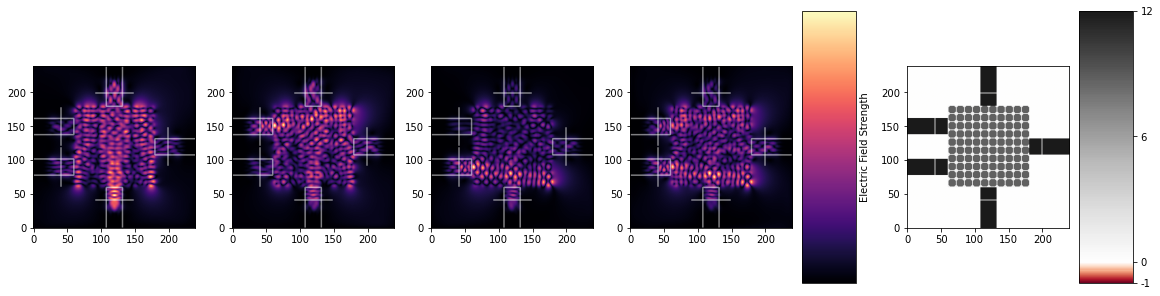

In [7]:
# Initialize the parametrization rho and the design region
epsrs = np.ones((num_dots, num_dots)) * 1
bg_rho, design_region, rods, input_slices, output_slices = init_domain(epsrs)

# Compute the permittivity from the design_region and the plasma rod permittivities
epsr_init = epsr_parameterization(epsrs, bg_rho, design_region, rods)

# Setup sources
source = insert_mode(omega1, dl, input_slices[0].x, input_slices[0].y, epsr_init, m=1) * -1
dataA = insert_mode(omega1, dl, input_slices[1].x, input_slices[1].y, epsr_init, m=1)
dataB = insert_mode(omega1, dl, input_slices[2].x, input_slices[2].y, epsr_init, m=1)

# Setup probes
probe = insert_mode(omega1, dl, output_slices[0].x, output_slices[0].y, epsr_init, m=1)
ground = insert_mode(omega1, dl, output_slices[1].x, output_slices[1].y, epsr_init, m=1)

# Simulate initial device
simulation, ax, fig = viz_sim(epsr_init, source, dataA, dataB, slices = input_slices + output_slices)

In [7]:
def save(i):
    if i == 0:
        return
        
    Ez00 = np.loadtxt('or_te/Ez00_%03d.csv' % i, delimiter=',')
    Ez01 = np.loadtxt('or_te/Ez01_%03d.csv' % i, delimiter=',')
    Ez10 = np.loadtxt('or_te/Ez10_%03d.csv' % i, delimiter=',')
    Ez11 = np.loadtxt('or_te/Ez11_%03d.csv' % i, delimiter=',')
    epsr = np.loadtxt('or_te/epsr_%03d.csv' % i, delimiter=',')
    
    fig, axs = plt.subplots(1, 5, constrained_layout=True, figsize=(16,4))
    epsr_graph = np.array(epsr, copy=True)
    epsr_graph[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0
    
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_xticks([])
    
    abslt(Ez00, outline=epsr_graph, ax=axs[0], cbar=False)
    abslt(Ez01, outline=epsr_graph, ax=axs[1], cbar=False)
    abslt(Ez10, outline=epsr_graph, ax=axs[2], cbar=False)
    abslt(Ez11, outline=epsr_graph, ax=axs[3], cbar=True)
    real(epsr, ax=axs[4], cmap='RdGy', cbar=True, vmin=-1, vmax=12)
    plt.savefig('or_te/normalized_%03d.png' % i, dpi=70)
    plt.close()

In [8]:
def callback_output_structure(iteration, of_list, epsrs):
    """Callback function to output fields and the structures (for making sweet gifs)"""
#     np.savetxt('and_te/iter_%03d.csv' % iteration, epsrs, delimiter=',')
    epsrs = epsrs.reshape((num_dots, num_dots))
    epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
    _, axs, fig = viz_sim(epsr, source, dataA, dataB, slices = input_slices + output_slices, log=iteration)
    plt.close()
    save(iteration)

In [9]:
# Define optimization objective
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

_, _, Ez00_0 = simulation.solve(source)
_, _, Ez01_0 = simulation.solve(source+dataB)
_, _, Ez10_0 = simulation.solve(source+dataA)
_, _, Ez11_0 = simulation.solve(source+dataA+dataB)
Ez_0 = [Ez00_0, Ez01_0, Ez10_0, Ez11_0]

In [10]:
def creat_objective(epsrs, bits):
    """Objective function called by optimizer
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """

    desired = []
    undesired = []
    normal = 1
    for i in range(len(bits)):
        if bits[i] == 1:
            desired.append(probe)
            undesired.append(ground)
            normal = normal * (mode_overlap(Ez_0[i], probe) - mode_overlap(Ez_0[i], ground))
        else:
            desired.append(ground)
            undesired.append(probe)
            normal = normal * (mode_overlap(Ez_0[i], ground) - mode_overlap(Ez_0[i], probe))
    print(normal)

    def objective(epsrs):
        epsrs = epsrs.reshape((num_dots, num_dots))
        epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
        simulation.eps_r = epsr
        
        _, _, Ez00 = simulation.solve(source)
        _, _, Ez01 = simulation.solve(source+dataB)
        _, _, Ez10 = simulation.solve(source+dataA)
        _, _, Ez11 = simulation.solve(source+dataA+dataB)
        Ez = [Ez00, Ez01, Ez10, Ez11]

        curr = np.prod([mode_overlap(Ez[i], desired[i]) - mode_overlap(Ez[i], undesired[i]) for i in range(len(bits))])  
        return curr / normal
    
    return objective

def simulate(bits):
    # Compute the gradient of the objective function using revere-mode differentiation
    objective = creat_objective(epsrs, bits)
    objective_jac = jacobian(objective, mode='reverse')
    # Maximize the objective function using an ADAM optimizer
    epsrs_optimum, _ = adam_optimize(objective, epsrs.flatten(), objective_jac,
                            Nsteps=Nsteps, direction='max', step_size=step_size, callback=callback_output_structure)
    return epsrs_optimum.reshape((num_dots, num_dots))

0.04606224402102237
Epoch:   1/1000 | Duration: 51.83 secs | Value: 1.000000e+00
Epoch:   2/1000 | Duration: 46.76 secs | Value: 2.118847e+00
Epoch:   3/1000 | Duration: 65.02 secs | Value: 2.407626e+00
Epoch:   4/1000 | Duration: 70.58 secs | Value: 2.768720e+00
Epoch:   5/1000 | Duration: 80.75 secs | Value: 3.544456e+00
Epoch:   6/1000 | Duration: 54.49 secs | Value: 4.593946e+00
Epoch:   7/1000 | Duration: 52.48 secs | Value: 5.508215e+00
Epoch:   8/1000 | Duration: 50.87 secs | Value: 6.301599e+00
Epoch:   9/1000 | Duration: 59.86 secs | Value: 7.366575e+00
Epoch:  10/1000 | Duration: 68.84 secs | Value: 8.807563e+00
Epoch:  11/1000 | Duration: 50.19 secs | Value: 1.047103e+01
Epoch:  12/1000 | Duration: 58.30 secs | Value: 1.204257e+01
Epoch:  13/1000 | Duration: 56.95 secs | Value: 1.352526e+01
Epoch:  14/1000 | Duration: 44.93 secs | Value: 1.522915e+01
Epoch:  15/1000 | Duration: 58.64 secs | Value: 1.657872e+01
Epoch:  16/1000 | Duration: 58.93 secs | Value: 1.813723e+01
Epoc

Epoch: 135/1000 | Duration: 46.93 secs | Value: 1.118105e+02
Epoch: 136/1000 | Duration: 46.13 secs | Value: 1.118515e+02
Epoch: 137/1000 | Duration: 45.05 secs | Value: 1.126133e+02
Epoch: 138/1000 | Duration: 44.82 secs | Value: 1.127600e+02
Epoch: 139/1000 | Duration: 45.67 secs | Value: 1.129739e+02
Epoch: 140/1000 | Duration: 48.06 secs | Value: 1.137687e+02
Epoch: 141/1000 | Duration: 47.21 secs | Value: 1.137702e+02
Epoch: 142/1000 | Duration: 46.14 secs | Value: 1.144966e+02
Epoch: 143/1000 | Duration: 46.95 secs | Value: 1.143800e+02
Epoch: 144/1000 | Duration: 45.64 secs | Value: 1.153629e+02
Epoch: 145/1000 | Duration: 46.09 secs | Value: 1.144347e+02
Epoch: 146/1000 | Duration: 46.23 secs | Value: 1.154334e+02
Epoch: 147/1000 | Duration: 68.98 secs | Value: 1.155809e+02
Epoch: 148/1000 | Duration: 71.75 secs | Value: 1.156580e+02
Epoch: 149/1000 | Duration: 45.11 secs | Value: 1.170442e+02
Epoch: 150/1000 | Duration: 45.13 secs | Value: 1.159252e+02
Epoch: 151/1000 | Durati

Epoch: 270/1000 | Duration: 49.09 secs | Value: 1.308385e+02
Epoch: 271/1000 | Duration: 48.53 secs | Value: 1.311872e+02
Epoch: 272/1000 | Duration: 49.28 secs | Value: 1.313947e+02
Epoch: 273/1000 | Duration: 47.72 secs | Value: 1.306983e+02
Epoch: 274/1000 | Duration: 51.66 secs | Value: 1.308253e+02
Epoch: 275/1000 | Duration: 50.49 secs | Value: 1.314707e+02
Epoch: 276/1000 | Duration: 47.29 secs | Value: 1.315307e+02
Epoch: 277/1000 | Duration: 48.30 secs | Value: 1.310161e+02
Epoch: 278/1000 | Duration: 59.81 secs | Value: 1.311858e+02
Epoch: 279/1000 | Duration: 49.18 secs | Value: 1.314675e+02
Epoch: 280/1000 | Duration: 48.67 secs | Value: 1.316073e+02
Epoch: 281/1000 | Duration: 48.36 secs | Value: 1.312173e+02
Epoch: 282/1000 | Duration: 49.58 secs | Value: 1.313250e+02
Epoch: 283/1000 | Duration: 49.43 secs | Value: 1.316923e+02
Epoch: 284/1000 | Duration: 49.23 secs | Value: 1.318345e+02
Epoch: 285/1000 | Duration: 48.49 secs | Value: 1.313626e+02
Epoch: 286/1000 | Durati

Epoch: 405/1000 | Duration: 48.70 secs | Value: 1.347697e+02
Epoch: 406/1000 | Duration: 49.16 secs | Value: 1.348843e+02
Epoch: 407/1000 | Duration: 51.71 secs | Value: 1.352261e+02
Epoch: 408/1000 | Duration: 49.42 secs | Value: 1.353233e+02
Epoch: 409/1000 | Duration: 51.73 secs | Value: 1.349020e+02
Epoch: 410/1000 | Duration: 49.35 secs | Value: 1.350157e+02
Epoch: 411/1000 | Duration: 50.69 secs | Value: 1.352758e+02
Epoch: 412/1000 | Duration: 49.84 secs | Value: 1.353888e+02
Epoch: 413/1000 | Duration: 48.62 secs | Value: 1.349631e+02
Epoch: 414/1000 | Duration: 49.83 secs | Value: 1.350232e+02
Epoch: 415/1000 | Duration: 50.63 secs | Value: 1.354764e+02
Epoch: 416/1000 | Duration: 72.68 secs | Value: 1.356005e+02
Epoch: 417/1000 | Duration: 65.44 secs | Value: 1.349630e+02
Epoch: 418/1000 | Duration: 66.61 secs | Value: 1.350780e+02
Epoch: 419/1000 | Duration: 72.22 secs | Value: 1.355102e+02
Epoch: 420/1000 | Duration: 64.07 secs | Value: 1.355899e+02
Epoch: 421/1000 | Durati

Epoch: 540/1000 | Duration: 49.55 secs | Value: 1.373488e+02
Epoch: 541/1000 | Duration: 47.10 secs | Value: 1.369599e+02
Epoch: 542/1000 | Duration: 50.82 secs | Value: 1.370409e+02
Epoch: 543/1000 | Duration: 48.65 secs | Value: 1.373169e+02
Epoch: 544/1000 | Duration: 49.16 secs | Value: 1.374208e+02
Epoch: 545/1000 | Duration: 49.07 secs | Value: 1.369768e+02
Epoch: 546/1000 | Duration: 50.38 secs | Value: 1.370581e+02
Epoch: 547/1000 | Duration: 49.88 secs | Value: 1.373905e+02
Epoch: 548/1000 | Duration: 45.32 secs | Value: 1.374865e+02
Epoch: 549/1000 | Duration: 43.94 secs | Value: 1.370034e+02
Epoch: 550/1000 | Duration: 48.86 secs | Value: 1.370885e+02
Epoch: 551/1000 | Duration: 50.26 secs | Value: 1.374480e+02
Epoch: 552/1000 | Duration: 49.19 secs | Value: 1.375331e+02
Epoch: 553/1000 | Duration: 50.17 secs | Value: 1.370478e+02
Epoch: 554/1000 | Duration: 52.15 secs | Value: 1.371330e+02
Epoch: 555/1000 | Duration: 49.31 secs | Value: 1.374940e+02
Epoch: 556/1000 | Durati

Epoch: 675/1000 | Duration: 57.59 secs | Value: 1.385565e+02
Epoch: 676/1000 | Duration: 48.61 secs | Value: 1.386051e+02
Epoch: 677/1000 | Duration: 49.69 secs | Value: 1.382518e+02
Epoch: 678/1000 | Duration: 49.05 secs | Value: 1.383659e+02
Epoch: 679/1000 | Duration: 50.66 secs | Value: 1.384816e+02
Epoch: 680/1000 | Duration: 49.21 secs | Value: 1.385193e+02
Epoch: 681/1000 | Duration: 48.96 secs | Value: 1.384140e+02
Epoch: 682/1000 | Duration: 48.61 secs | Value: 1.385244e+02
Epoch: 683/1000 | Duration: 51.19 secs | Value: 1.383858e+02
Epoch: 684/1000 | Duration: 49.89 secs | Value: 1.384532e+02
Epoch: 685/1000 | Duration: 48.54 secs | Value: 1.385155e+02
Epoch: 686/1000 | Duration: 48.52 secs | Value: 1.385760e+02
Epoch: 687/1000 | Duration: 50.13 secs | Value: 1.384185e+02
Epoch: 688/1000 | Duration: 50.77 secs | Value: 1.385314e+02
Epoch: 689/1000 | Duration: 48.70 secs | Value: 1.384601e+02
Epoch: 690/1000 | Duration: 50.09 secs | Value: 1.384937e+02
Epoch: 691/1000 | Durati

Epoch: 810/1000 | Duration: 120.34 secs | Value: 1.393471e+02
Epoch: 811/1000 | Duration: 143.39 secs | Value: 1.391916e+02
Epoch: 812/1000 | Duration: 123.06 secs | Value: 1.393199e+02
Epoch: 813/1000 | Duration: 103.63 secs | Value: 1.391837e+02
Epoch: 814/1000 | Duration: 175.92 secs | Value: 1.392237e+02
Epoch: 815/1000 | Duration: 108.81 secs | Value: 1.393566e+02
Epoch: 816/1000 | Duration: 138.78 secs | Value: 1.394438e+02
Epoch: 817/1000 | Duration: 184.46 secs | Value: 1.391108e+02
Epoch: 818/1000 | Duration: 100.89 secs | Value: 1.392028e+02
Epoch: 819/1000 | Duration: 126.51 secs | Value: 1.393681e+02
Epoch: 820/1000 | Duration: 133.58 secs | Value: 1.393764e+02
Epoch: 821/1000 | Duration: 112.90 secs | Value: 1.392709e+02
Epoch: 822/1000 | Duration: 93.21 secs | Value: 1.394242e+02
Epoch: 823/1000 | Duration: 111.99 secs | Value: 1.391780e+02
Epoch: 824/1000 | Duration: 104.13 secs | Value: 1.392305e+02
Epoch: 825/1000 | Duration: 93.35 secs | Value: 1.394339e+02
Epoch: 826

Epoch: 944/1000 | Duration: 56.55 secs | Value: 1.398316e+02
Epoch: 945/1000 | Duration: 54.33 secs | Value: 1.399117e+02
Epoch: 946/1000 | Duration: 52.89 secs | Value: 1.400248e+02
Epoch: 947/1000 | Duration: 53.94 secs | Value: 1.397045e+02
Epoch: 948/1000 | Duration: 54.27 secs | Value: 1.397727e+02
Epoch: 949/1000 | Duration: 53.95 secs | Value: 1.399830e+02
Epoch: 950/1000 | Duration: 53.81 secs | Value: 1.400275e+02
Epoch: 951/1000 | Duration: 54.66 secs | Value: 1.397546e+02
Epoch: 952/1000 | Duration: 53.86 secs | Value: 1.398471e+02
Epoch: 953/1000 | Duration: 55.42 secs | Value: 1.399303e+02
Epoch: 954/1000 | Duration: 61.02 secs | Value: 1.399653e+02
Epoch: 955/1000 | Duration: 60.06 secs | Value: 1.398638e+02
Epoch: 956/1000 | Duration: 59.85 secs | Value: 1.399591e+02
Epoch: 957/1000 | Duration: 66.05 secs | Value: 1.398507e+02
Epoch: 958/1000 | Duration: 79.48 secs | Value: 1.399190e+02
Epoch: 959/1000 | Duration: 76.32 secs | Value: 1.399295e+02
Epoch: 960/1000 | Durati

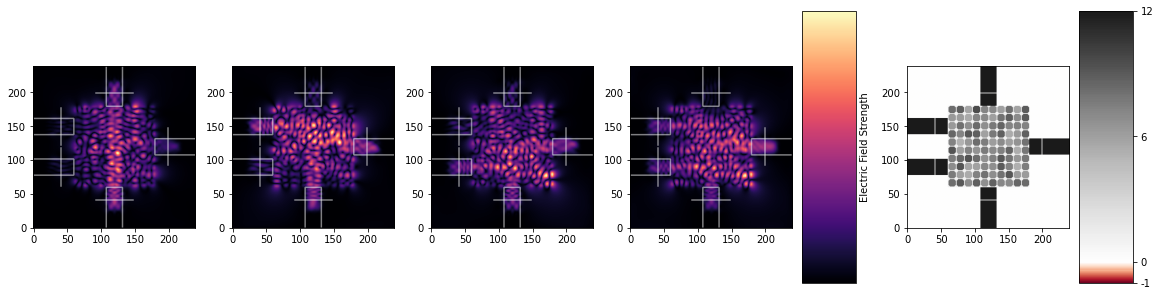

In [11]:
# Simulate optimal device
epsrs_optimum = simulate([0, 1, 1, 1])
grid = (epsr_train_max-epsr_train_min) * (npa.arctan(epsrs_optimum)/np.pi + 0.5) + epsr_train_min
print(grid)
epsrs = epsr_parameterization(epsrs_optimum, bg_rho, design_region, rods)
_, ax, fig = viz_sim(epsrs, source, dataA, dataB, slices = input_slices + output_slices)

In [33]:
obj = [[], [], [], []]
for i in range(1, 1000):
    print(i)
    Ez00 = np.loadtxt('and_te/Ez00_%03d.csv' % i, delimiter=',')
    Ez01 = np.loadtxt('and_te/Ez01_%03d.csv' % i, delimiter=',')
    Ez10 = np.loadtxt('and_te/Ez10_%03d.csv' % i, delimiter=',')
    Ez11 = np.loadtxt('and_te/Ez11_%03d.csv' % i, delimiter=',')
    epsr = np.loadtxt('or_te/epsr_%03d.csv' % i, delimiter=',')
    
#     fig, axs = plt.subplots(1, 5, constrained_layout=True, figsize=(16,4))
#     epsr_graph = np.array(epsr, copy=True)
#     epsr_graph[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0
    
#     for ax in axs:
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_yticks([])
#         ax.set_xticks([])
    
    
    obj[0].append([mode_overlap(Ez00, probe)/(mode_overlap(Ez00, probe)+mode_overlap(Ez00, ground)), \
                  mode_overlap(Ez00, ground)/(mode_overlap(Ez00, probe)+mode_overlap(Ez00, ground))])
    obj[1].append([mode_overlap(Ez01, probe)/(mode_overlap(Ez01, probe)+mode_overlap(Ez01, ground)), \
                  mode_overlap(Ez01, ground)/(mode_overlap(Ez01, probe)+mode_overlap(Ez01, ground))])    
    obj[2].append([mode_overlap(Ez10, probe)/(mode_overlap(Ez10, probe)+mode_overlap(Ez10, ground)), \
                  mode_overlap(Ez10, ground)/(mode_overlap(Ez10, probe)+mode_overlap(Ez10, ground))])
    obj[3].append([mode_overlap(Ez11, probe)/(mode_overlap(Ez11, probe)+mode_overlap(Ez11, ground)), \
                  mode_overlap(Ez11, ground)/(mode_overlap(Ez11, probe)+mode_overlap(Ez11, ground))])
    
#     abslt(Ez00, outline=epsr_graph, ax=axs[0], cbar=False, vmax=1.5e-6)
#     abslt(Ez01, outline=epsr_graph, ax=axs[1], cbar=False, vmax=1.5e-6)
#     abslt(Ez10, outline=epsr_graph, ax=axs[2], cbar=False, vmax=1.5e-6)
#     abslt(Ez11, outline=epsr_graph, ax=axs[3], cbar=True, vmax=1.5e-6)
#     real(epsr, ax=axs[4], cmap='RdGy', cbar=True, vmin=-1, vmax=12)
#     plt.savefig('and_te/normalized_%03d.png' % i, dpi=70)
#     plt.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


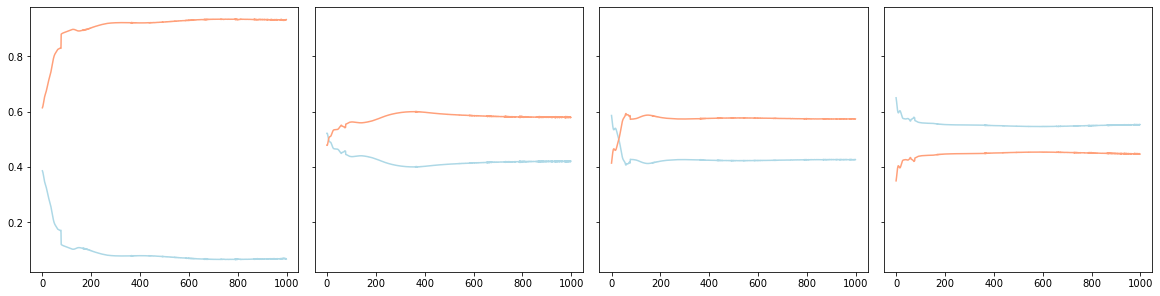

In [34]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16,4), sharex='row', sharey='row')
axs[0].plot([obj[0][i][0] for i in range(len(obj[0]))], color='lightblue')
axs[1].plot([obj[1][i][0] for i in range(len(obj[1]))], color='lightblue')
axs[2].plot([obj[2][i][0] for i in range(len(obj[2]))], color='lightblue')
axs[3].plot([obj[3][i][0] for i in range(len(obj[3]))], color='lightblue')
axs[0].plot([obj[0][i][1] for i in range(len(obj[0]))], color='lightsalmon')
axs[1].plot([obj[1][i][1] for i in range(len(obj[1]))], color='lightsalmon')
axs[2].plot([obj[2][i][1] for i in range(len(obj[2]))], color='lightsalmon')
axs[3].plot([obj[3][i][1] for i in range(len(obj[3]))], color='lightsalmon')

plt.savefig('and_te/optimization.png', dpi=70)